Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5326 - loss: 2.0197 - val_accuracy: 0.9690 - val_loss: 0.2244
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9797 - loss: 0.1656 - val_accuracy: 0.9876 - val_loss: 0.0789
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9944 - loss: 0.0525 - val_accuracy: 0.9876 - val_loss: 0.0524
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9990 - loss: 0.0272 - val_accuracy: 0.9904 - val_loss: 0.0358
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9981 - loss: 0.0183 - val_accuracy: 0.9893 - val_loss: 0.0348
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9985 - loss: 0.0143 - val_accuracy: 0.9944 - val_loss: 0.0219
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9996 - loss: 0.0098 - val_accuracy: 0.9932 - val_loss: 0.0220
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9998 - loss: 0.0069 - val_accuracy

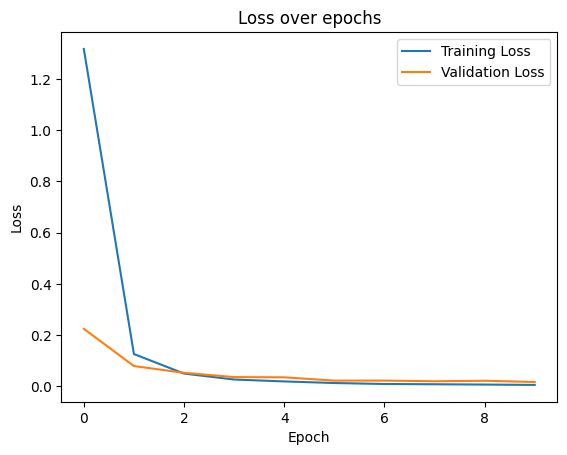

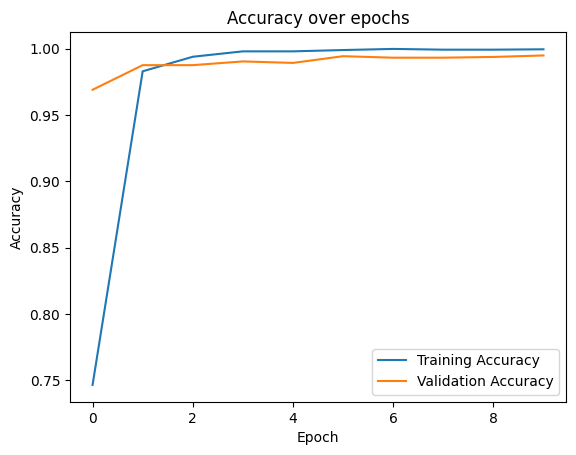

In [17]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization, Embedding, Dropout, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import json
# import matplotlib
# matplotlib.use('Agg')  #אפשר לשנות ל TkAgg
from sklearn.metrics import classification_report, confusion_matrix




with open('/content/cases.json', 'r', encoding='utf-8') as f:
    label_map = json.load(f)



df = pd.read_csv("/content/emergency_cases_clean5_expend_7.csv")  # להתייחס כסטרינג עם התעלמות מטאבים לרדת שורה וכו

df['label'] = df['label'].map(label_map)
df = df.dropna(subset=['label'])  # הסרת שורות שה-label שלהן לא נמצא במילון
df.loc[:, 'label'] = df['label'].astype(int)


texts = df['text'].astype(str).to_numpy()
labels = df['label'].to_numpy()

texts_train, texts_val, labels_train, labels_val = train_test_split(
    texts, labels, test_size=0.2
     , random_state=42,stratify=labels
)  # 20 אחוז לבדיקה
# חושב להגדיר את הרנדום כדי שיוכל להשוות את התוצאות ולא יחלק את הדאטה סט בצורה שונה כל פעם

SEQUENCE_LEN = 200
VOCAB_SIZE = 5000

encoder = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LEN
)
encoder.adapt(texts_train)  # מילון למילים הנפוצות ביותר מספר נמוך יותר כשתדיר יותר

# אימון: loss על train
# בדיקה: loss על test/validation


# הגדרה
# מה המודל עושה כשהוא מקבל קלט
# model = tf.keras.Sequential([
#     encoder,  # המרה למספרים
#     Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),  # המרה לוקטורים עם משמעות
#     # מתעלם מאפסים של פדינג
#     # ה-padding מתבצע אוטומטית בתוך שכבת TextVectorization כי אמרתי לו אורך 100
#     Dropout(0.3),  # למנוע אוברפיטינג
#     Bidirectional(LSTM(32, dropout=0.2)),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.4),  # זה אחרי שכבה צפופה לכן יותר אחוזים למנוע אוברפיטינג
#     Dense(len(label_map), activation='softmax')  # 3 אופציות לפלט
# ])
model = tf.keras.Sequential([
    encoder,
    Embedding(input_dim=VOCAB_SIZE, output_dim=32, mask_zero=True),
    Bidirectional(LSTM(32, dropout=0.2)),
    Dropout(0.2),
    Dense(len(label_map), activation='softmax')
])
# הכנה לאימון לפי מה להתייחס ולבדוק נתונים
model.compile(
    loss='sparse_categorical_crossentropy',  # Sparse תוויות הן מספר אחד בודד (ולא רשימת אפסים ואחד בודד)
    # כנראה אני אשנה במודל של ה12 כי הוא יכול לחשוב שיש יחס למספור הקטגוריות
    # לשנות לone-hot encoding אחרי שמשנים את הקטגוריות לסוג של בינאריים

    # איך לחשב את הלוס
    optimizer='adam',  # מתאים באופן דינמי את קצב הלמידה תוך כדי אימון
    # איך לייעל
    # מומנטום עוזר למודל להתמיד בכיוון שהוא בחר בו
    # אדפטציה עוזרת למודל להתאים את קצב הלמידה
    # adam משלב את שניהם
    metrics=['accuracy']
)
# אם המודל הפסיק ללמוד חבל על הזמן וגם למנוע אוברפיטנג
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# אימון בפועל
history = model.fit(
    texts_train,
    labels_train,
    validation_data=(texts_val, labels_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)
# בודק את ביצועי המודל על הדאטה שהוא לא ראה
loss, accuracy = model.evaluate(texts_val, labels_val)
print(f"Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")  # לעגל 4 ספרות אחרי הנקודה

preds = model.predict(texts_val)
pred_labels = preds.argmax(axis=1)

print(confusion_matrix(labels_val, pred_labels))
print(classification_report(labels_val, pred_labels, digits=3))

# אם Training Loss יורד חזק, אבל Validation Loss מתחיל לעלות — סימן שהמודל זוכר את הדאטה ולא מת-generalize טוב (אוברפיטינג)
# ציור Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ציור Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.save("/content/saved_model.keras") #לשמור את המודל

In [15]:
import pandas as pd
import numpy as np
from collections import Counter
def clean_csv(input_file, output_file):
  try:
        df = pd.read_csv(input_file)
  except Exception as e:
        print(f"Error reading file: {e}")
        return
  initial_count = len(df)
  df.drop_duplicates(inplace=True)
  duplicates_removed = initial_count - len(df)
  df.replace('', np.nan, inplace=True)
  df.dropna(inplace=True)
  empty_rows_removed = initial_count - duplicates_removed - len(df)

  # Count rows per label
  if 'label' in df.columns:
       label_counts = Counter(df['label'])
       print("Rows per label:")
       for label, count in label_counts.items():
            print(f"{label}: {count}")
  else:
       print("No 'label' column found")

    # Shuffle rows (keeping header)
  df = df.sample(frac=1).reset_index(drop=True)

    # Save cleaned file
  try:
      df.to_csv(output_file, index=False)
      print(f"\nSuccessfully processed file:")
      print(f" - Removed {duplicates_removed} duplicate rows")
      print(f" - Removed {empty_rows_removed} empty rows")
      print(f" - Final row count: {len(df)}")
      print(f" - Saved to: {output_file}")
  except Exception as e:
      print(f"Error saving file: {e}")
clean_csv('/content/emergency_cases_clean4 - Copy.csv','/content/emergency_cases_clean5.csv')


Rows per label:
choking: 75
rabies: 100
fractures: 100
scorpion_sting: 100
wounds: 100
electric_shock: 85
snake_bite: 100
fainting: 81
drowning: 100
cpr: 75
bee_sting: 100
burns: 100
label: 1

Successfully processed file:
 - Removed 0 duplicate rows
 - Removed 0 empty rows
 - Final row count: 1117
 - Saved to: /content/emergency_cases_clean5.csv


In [18]:
df.head()

,text,label,need_amb,source,is_synthetic
0,Minor shock from appliance - small burn on fin...,3.0,0.0,(Synthetic),1.0
1,Scorpion sting - child stopped crying after me...,8.0,0.0,(Synthetic),1.0
2,Single wasp sting - localized redness and itching,6.0,0.0,https://www.cdc.gov,0.0
3,Fainted briefly in heat - recovered with water,1.0,0.0,(Synthetic),1.0
4,Bat bite while sleeping - small puncture on sh...,5.0,1.0,https://www.cdc.gov,0.0


In [ ]:
import csv
import requests
from bs4 import BeautifulSoup
from duckduckgo_search import DDGS
import time
import openai
import re

openai.api_key = "YOUR_OPENAI_API_KEY"  # <-- הכניסי את המפתח שלך כאן

categories = {
    "cpr": 0,
    "fainting": 1,
    "drowning": 2,
    "electric_shock": 3,
    "choking": 4,
    "rabies": 5,
    "bee_sting": 6,
    "snake_bite": 7,
    "scorpion_sting": 8,
    "wounds": 9,
    "burns": 10,
    "fractures": 11
}

medical_sources = [
    "site:mayoclinic.org",
    "site:cdc.gov",
    "site:nhs.uk",
    "site:healthline.com",
    "site:redcross.org.uk",
    "site:stjohn.org.nz",
    "site:pubmed.ncbi.nlm.nih.gov"
]

def duckduckgo_search(query, max_results=5):
    with DDGS() as ddgs:
        return [r['href'] for r in ddgs.text(query, max_results=max_results)]

def fetch_text_from_url(url):
    try:
        res = requests.get(url, timeout=10, headers={"User-Agent": "Mozilla/5.0"})
        soup = BeautifulSoup(res.text, 'html.parser')
        paragraphs = soup.find_all('p')
        return [p.get_text().strip() for p in paragraphs if len(p.get_text().strip()) > 40]
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return []

def generate_synthetic_example(paragraph, label, need_amb):
    prompt = f"""Based on the following medical information:\n\n\"{paragraph}\"\n\nWrite a natural language description of what someone (or a bystander) might say in an emergency. Include relevant symptoms, urgency, and emotions. Be realistic and human.\n\nOutput only the quote, no explanation."""
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        return response.choices[0].message['content'].strip()
    except Exception as e:
        print(f"OpenAI error: {e}")
        return ""

with open('first_aid_dataset_large.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['text', 'label', 'need_amb', 'source_url', 'is_synthetic']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for label in categories:
        print(f"=== Collecting data for: {label} ===")
        query = f"{label.replace('_', ' ')} first aid treatment"

        # שילוב מקורות רפואיים
        for domain in medical_sources:
            urls = duckduckgo_search(f"{query} {domain}", max_results=3)
            for url in urls:
                paras = fetch_text_from_url(url)
                for p in paras:
                    if len(p.split()) < 30 or "cookie" in p.lower() or "policy" in p.lower():
                        continue

                    synthetic = generate_synthetic_example(p, label, need_amb=1 if label in ['cpr', 'drowning', 'choking', 'snake_bite', 'fractures', 'electric_shock', 'rabies', 'scorpion_sting', 'burns'] else 0)
                    if synthetic:
                        writer.writerow({
                            'text': synthetic,
                            'label': label,
                            'need_amb': 1 if label in ['cpr', 'drowning', 'choking', 'snake_bite', 'fractures', 'electric_shock', 'rabies', 'scorpion_sting', 'burns'] else 0,
                            'source_url': url,
                            'is_synthetic': 'yes'
                        })

                time.sleep(1)  # למנוע חסימה

print("✅ Done generating dataset")


=== Collecting data for: cpr ===
OpenAI error: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

OpenAI error: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

OpenA

DuckDuckGoSearchException: https://lite.duckduckgo.com/lite/ 202 Ratelimit